# Missing Data Patterns

Haziq Jamil

## Load data

In [ ]:
#| echo: true
#| eval: true 
#| file: data.R
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Loading required package: sf
Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

here() starts at /Users/haziqj/github_local/house-data

Rows: 31116 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): quarter, kampong, mukim, district, type, tenure, status, agent, s...
dbl   (7): id, price, plot_area, floor_area, storeys, beds, baths
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 39 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): quarter
dbl (1): rppi

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

## Missing data patterns

Let’s take a look at the missing data patterns in the housing data. For
simplicity, we focus on the year 2024 and houses in the Brunei-Muara
district.

In [ ]:
hsp24 <- 
  hsp |>
  filter(year(date) == 2024, district == "Brunei-Muara") |>
  select(price, mukim, plot_area, floor_area, beds, baths)
glimpse(hsp24)

Rows: 2,698
Columns: 6
$ price      <dbl> 100000, 265000, 188000, 175000, 300000, 300000, 208000, 218…
$ mukim      <chr> "Mukim Kilanas", "Mukim Kilanas", "Mukim Lumapas", "Mukim M…
$ plot_area  <dbl> 0.2500, 0.0810, 0.1000, 0.0490, 0.1340, 0.1500, 0.0420, 0.0…
$ floor_area <dbl> 1500.00, 2382.00, 1765.00, 1700.00, 2000.00, 2000.00, 2588.…
$ beds       <dbl> 3, 4, NA, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4, N…
$ baths      <dbl> 3, 3, NA, 2, 2, 2, 4, 4, 3, 3, 3, 3, 3, 4, 3, 5, 3, 3, 4, N…

There are a total of 2698 houses in the Brunei-Muara district in 2024.
There are a couple of missing values in the data set, 1013 to be exact.
We can visualise this using the `{mice}` and `{ggmice}` package.

In [ ]:
library(mice)


Attaching package: 'mice'

The following object is masked from 'package:stats':

    filter

The following objects are masked from 'package:base':

    cbind, rbind


Attaching package: 'ggmice'

The following objects are masked from 'package:mice':

    bwplot, densityplot, stripplot, xyplot

Let’s take a look at the missing data patterns in the housing data.

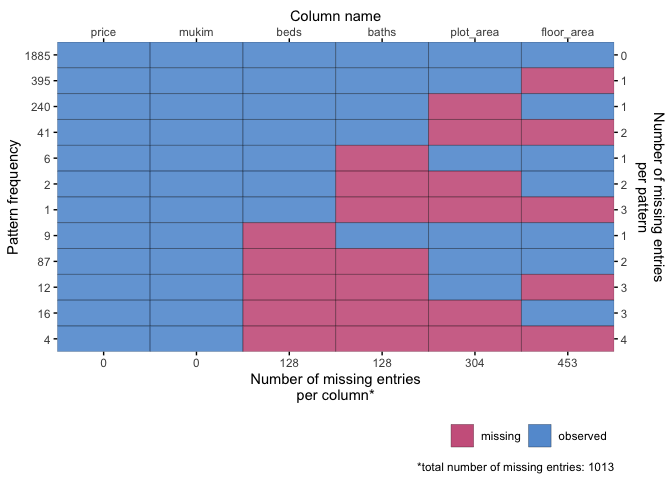

In [ ]:
plot_pattern(hsp24, square = !TRUE, rotate = !TRUE) 

We first note that in this instance, there are no missing values for
price and spatial location. However, there is a pattern in the missing
data, so the missingness mechanism is not *completely* at random. It
seems to be the case that the missing data is *at random* (MAR), which
means that the missing data is dependent on the observed data. We can
test this using a logistic regression.

In [ ]:
hsp24 |>
  mutate(across(everything(), is.na)) |>
  glm(formula = beds ~ plot_area + floor_area + baths, family = binomial) |>
  summary()


Call:
glm(formula = beds ~ plot_area + floor_area + baths, family = binomial, 
    data = mutate(hsp24, across(everything(), is.na)))

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -5.5048     0.3427 -16.065   <2e-16 ***
plot_areaTRUE   -1.0541     0.6745  -1.563    0.118    
floor_areaTRUE  -0.5194     0.6731  -0.772    0.440    
bathsTRUE        8.4491     0.5281  15.998   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1030.18  on 2697  degrees of freedom
Residual deviance:  181.66  on 2694  degrees of freedom
AIC: 189.66

Number of Fisher Scoring iterations: 8

What we can see is that the `beds` variable missingness is dependent on
the `bath` missingness, which means that if the number of bathrooms is
missing, the number of bedrooms is also likely to be missing (odds ratio
increases by $e^{8.52} = 5014.1$).

On the other hand, the missingness of the `floor_area` variable does not
seem to be dependent on the other variables, which means that this
variable is missing *completely* at random (MCAR).

In [ ]:
hsp24 |>
  mutate(across(everything(), is.na)) |>
  glm(formula = floor_area ~ plot_area + beds + baths, family = binomial) |>
  summary()


Call:
glm(formula = floor_area ~ plot_area + beds + baths, family = binomial, 
    data = mutate(hsp24, across(everything(), is.na)))

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.57205    0.05531 -28.423   <2e-16 ***
plot_areaTRUE -0.13584    0.16938  -0.802    0.423    
bedsTRUE      -0.62988    0.68264  -0.923    0.356    
bathsTRUE      0.29536    0.66749   0.443    0.658    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2441.9  on 2697  degrees of freedom
Residual deviance: 2439.2  on 2694  degrees of freedom
AIC: 2447.2

Number of Fisher Scoring iterations: 4

Let’s visualise the missing points as a scatter plot.

Please verify whether this matches the requested mapping variable.

`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

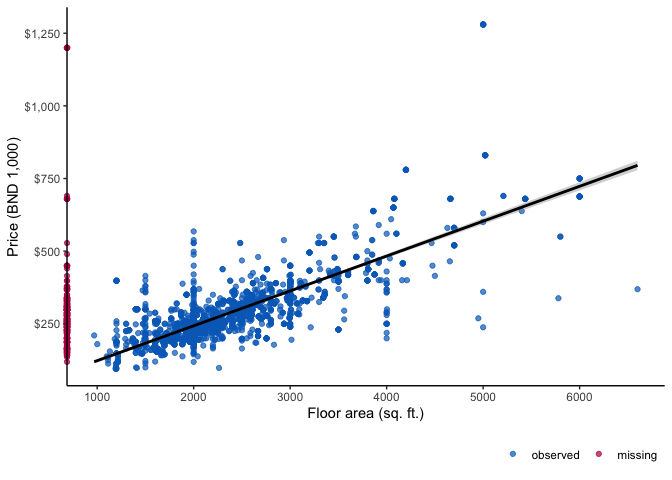

In [ ]:
ggmice(hsp24, aes(y = price / 1000, x = floor_area)) +
  geom_point() +
  geom_smooth(method = "lm", col = "black") +
  scale_y_continuous(labels = scales::dollar_format()) +
  labs(y = "Price (BND 1,000)", x = "Floor area (sq. ft.)")

## Simulating missingness mechanism

Suppose we have a full data set and we want to simulate a missingness
mechanism. For this purpose, we have the following data sets:

1.  DATA SET A: The original data set containing missing values.
2.  DATA SET B: The “complete cases” data set, i.e. subsetting DATA SET
    A containing no missing values whatsoever.

Suppose we want to induce missingness in B with the same pattern as A.
Here’s the code to do it:

In [ ]:
set.seed(123)
datA <- hsp24
datB <- drop_na(hsp24)

# Step 1: Calculate the proportion of missing values for each variable in the original data
pat <-
  mice::md.pattern(datA, plot = FALSE) |>
  as.data.frame() |>
  rownames_to_column(var = "freq") |>
  select(-V7) |>
  slice_head(n = -1) |>
  unite("pattern", beds:floor_area, sep = "", remove = FALSE) |>
  mutate(
    freq = as.numeric(freq),
    prop = freq / sum(freq),
    id = row_number()
  ) |> 
  as_tibble()
pat

# A tibble: 12 × 10
    freq price mukim pattern  beds baths plot_area floor_area     prop    id
   <dbl> <dbl> <dbl> <chr>   <dbl> <dbl>     <dbl>      <dbl>    <dbl> <int>
 1  1885     1     1 1111        1     1         1          1 0.699        1
 2   395     1     1 1110        1     1         1          0 0.146        2
 3   240     1     1 1101        1     1         0          1 0.0890       3
 4    41     1     1 1100        1     1         0          0 0.0152       4
 5     6     1     1 1011        1     0         1          1 0.00222      5
 6     2     1     1 1001        1     0         0          1 0.000741     6
 7     1     1     1 1000        1     0         0          0 0.000371     7
 8     9     1     1 0111        0     1         1          1 0.00334      8
 9    87     1     1 0011        0     0         1          1 0.0322       9
10    12     1     1 0010        0     0         1          0 0.00445     10
11    16     1     1 0001        0     0         0      

mis
 0000  0001  0010  0011  0111  1001  1011  1100  1101  1110  1111 
0.001 0.005 0.006 0.033 0.006 0.001 0.002 0.013 0.084 0.149 0.700 

 [1] 0.001 0.006 0.004 0.032 0.003 0.000 0.001 0.002 0.015 0.089 0.146 0.699

Let’s visualise the missing data patterns in the simulated data set.

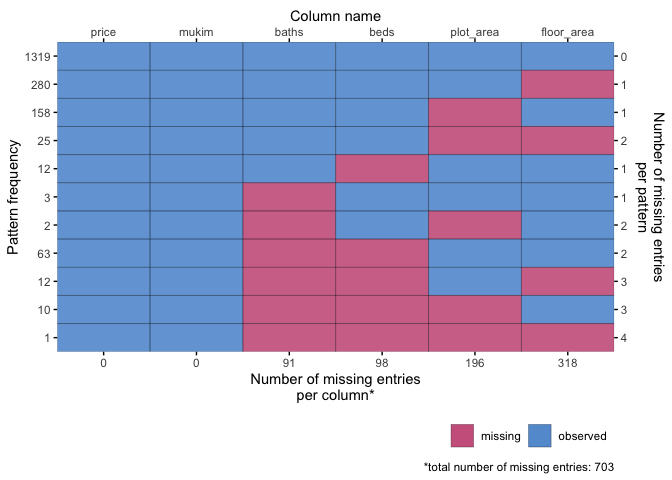

In [ ]:
plot_pattern(datB, square = !TRUE, rotate = !TRUE) 

Some patterns are there, but some are not. This is expected when some of
the missing patterns are rare.

## Main article

patterns.
ℹ All missing data patterns are shown.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

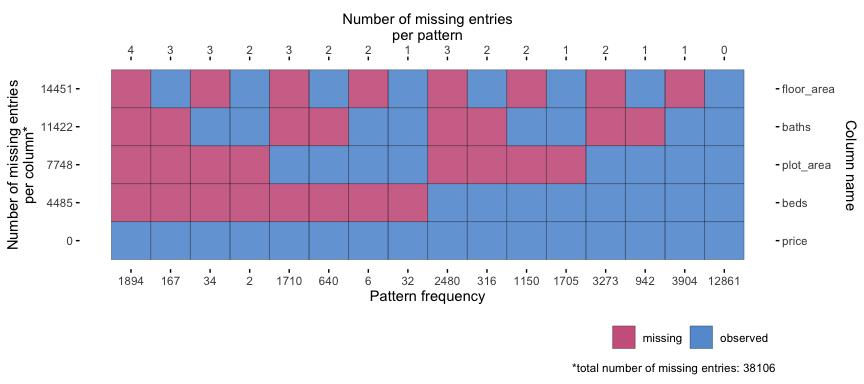

In [ ]:
#| message: false
#| warning: false
#| echo: false
#| label: fig-missing-pattern
#| fig-cap: Missing data patterns for key house characteristics.
#| out-width: 100%
#| fig-width: 9
#| fig-height: 4
hsp |>
  dplyr::select(price, plot_area, floor_area, beds, baths) |>
  plot_pattern(npat = 16) +
  coord_flip() +
  theme(aspect.ratio = 0.3)